In [0]:
import os, sys, shutil, h5py, json
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import scipy
import numpy as np
import tensorflow as tf
import pickle
import numpy
import matplotlib.pyplot as plt
import glob

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from shutil import copy

from keras.models import Model
from keras.models import model_from_json
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Cropping2D, ZeroPadding2D, Permute, Reshape, Input, Flatten
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

%cd /content/gdrive/My\ Drive/Deep_Learning/Images_Cropped/

with open("Training_set_NoAugmentation_NoNormalization.pickle", 'rb') as handle:
  training_samples = pickle.load(handle)

with open("Test_set_NoAugmentation_NoNormalization.pickle", 'rb') as handle:
  test_samples = pickle.load(handle)

Mounted at /content/gdrive
/content/gdrive/My Drive/Deep_Learning/Images_Cropped


In [0]:
# Normalization functions
from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank

def normalization_local_equalization(image):
  #image = img_as_ubyte(image[:, :, 0]) 
  image = image[:, :, 0]
  selem = disk(40) # The neighborhood expressed as a 2-D array of 1’s and 0’s.
  return rank.equalize(image, selem=selem)/255

In [0]:
np.random.seed(45)
np.random.shuffle(training_samples)
np.random.shuffle(test_samples)

training_images = []
training_labels = []
test_images = []
test_labels = []

for picture, label, _, _ in training_samples:
  training_images.append(normalization_local_equalization(picture).reshape(420, 420, 1))
  training_labels.append(label)

for picture, label, _, _ in test_samples:
  test_images.append(normalization_local_equalization(picture).reshape(420, 420, 1))
  test_labels.append(label)

training_images = np.array(training_images)
training_labels = np.array(training_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(34, 420, 420, 1)
(420, 420, 1)


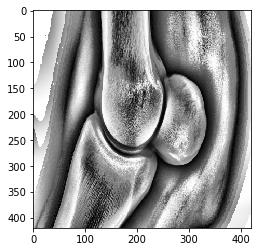

In [0]:
check_image = test_images[0]
print(test_images.shape)
print(check_image.shape)
plt.imshow(check_image[:, :, 0], cmap=plt.get_cmap('gray'))
#print(check_image)

In [0]:
# Intialize model
def initialize_conv_network(input_, target_):
    input_img = Input(shape=input_.shape[1:])
    x = input_img

    # ---------
    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Dropout(0.3)(x)

    # ---------
    # No padding here
    x = Conv2D(512, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(512, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # ---------
    # No padding here
    x = Conv2D(15, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Flatten()(x)

    x = Dense(2, kernel_initializer='he_normal')(x)
    final_output = Activation('softmax')(x)
    model = Model(inputs=input_img, outputs=final_output)
    #print(model.summary())
    #exit()
    return model

In [0]:
# Intialize model
def initialize_conv_network_dilation_v1(input_, target_):
    input_img = Input(shape=input_.shape[1:])
    x = input_img

    # ---------
    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(32, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(32, (4, 4), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(64, (4, 4), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(128, (4, 4), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Dropout(0.3)(x)

    # ---------
    # No padding here
    x = Conv2D(512, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(512, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # ---------
    # No padding here
    x = Conv2D(15, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Flatten()(x)

    x = Dense(2, kernel_initializer='he_normal')(x)
    final_output = Activation('softmax')(x)
    model = Model(inputs=input_img, outputs=final_output)
    #print(model.summary())
    #exit()
    return model

In [0]:
# Intialize model
def initialize_conv_network_dilation_v2(input_, target_):
    input_img = Input(shape=input_.shape[1:])
    x = input_img

    # ---------
    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(32, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Dropout(0.3)(x)

    # ---------
    # No padding here
    x = Conv2D(512, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(512, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # ---------
    # No padding here
    x = Conv2D(15, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Flatten()(x)

    x = Dense(2, kernel_initializer='he_normal')(x)
    final_output = Activation('softmax')(x)
    model = Model(inputs=input_img, outputs=final_output)
    #print(model.summary())
    #exit()
    return model

In [0]:
# Intialize model
def initialize_conv_network_dilation_v3(input_, target_):
    input_img = Input(shape=input_.shape[1:])
    x = input_img

    # ---------
    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(32, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(32, (4, 4), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(64, (4, 4), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(128, (4, 4), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Dropout(0.3)(x)

    # ---------
    # No padding here
    x = Conv2D(512, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(512, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # ---------
    # No padding here
    x = Conv2D(15, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Flatten()(x)

    x = Dense(2, kernel_initializer='he_normal')(x)
    final_output = Activation('softmax')(x)
    model = Model(inputs=input_img, outputs=final_output)
    #print(model.summary())
    #exit()
    return model

In [0]:
# Intialize model
def initialize_conv_network_dilation_v4(input_, target_):
    input_img = Input(shape=input_.shape[1:])
    x = input_img

    # ---------
    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(32, (4, 4), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(64, (4, 4), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(128, (4, 4), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    # ---------
    # No padding here
    x = Conv2D(512, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(512, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # ---------
    # No padding here
    x = Conv2D(15, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Flatten()(x)

    x = Dense(2, kernel_initializer='he_normal')(x)
    final_output = Activation('softmax')(x)
    model = Model(inputs=input_img, outputs=final_output)
    #print(model.summary())
    #exit()
    return model

In [0]:
# Intialize model
def initialize_conv_network_dilation_v5(input_, target_):
    input_img = Input(shape=input_.shape[1:])
    x = input_img

    # ---------
    x = ZeroPadding2D(padding=(2, 2), data_format='channels_last')(x)
    x = Conv2D(32, (5, 5), strides=(2, 2), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(32, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(64, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Dropout(0.3)(x)

    # ---------
    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=(1, 1), data_format='channels_last')(x)
    x = Conv2D(128, (3, 3), dilation_rate=2, kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Dropout(0.3)(x)

    # ---------
    # No padding here
    x = Conv2D(512, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(512, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # ---------
    # No padding here
    x = Conv2D(15, (1, 1), strides=(1, 1), kernel_initializer='he_uniform', padding='valid', data_format='channels_last')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Flatten()(x)

    x = Dense(2, kernel_initializer='he_normal')(x)
    final_output = Activation('softmax')(x)
    model = Model(inputs=input_img, outputs=final_output)
    #print(model.summary())
    #exit()
    return model

In [0]:
#model = initialize_conv_network(training_images, training_labels)
#print(model.summary())

In [0]:
model = initialize_conv_network_dilation_v4(training_images, training_labels)
print(model.summary())












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 420, 420, 1)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 424, 424, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 210, 210, 32)      832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 210, 210, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 210, 210, 32)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 212, 212, 32)      0        

In [0]:
PATIENCE = 50
#VAL_SPLIT = 0.25
BATCH_SIZE = 2
EPOCHS = 100

save_name = 'aDilation_v4_fixed'
loss_func = 'sparse_categorical_crossentropy'
AO = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

max_train_acc = []
max_val_acc = []

for i in range(10):
  print(i)
  if i == 0:
    model.compile(loss=loss_func, optimizer=AO, metrics=['accuracy'])
    json_string = model.to_json()
    with open(str(save_name) + '.json', 'w') as f:
        f.write(json_string)

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=PATIENCE, verbose=1, mode='max')
  checkpoint = ModelCheckpoint(str(save_name) + "_" + str(i) +  '.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint, early_stopping]

  history = model.fit(training_images, training_labels, batch_size=BATCH_SIZE, validation_data=(test_images, test_labels), epochs=EPOCHS, callbacks=callbacks_list)
  '''
  scipy.io.savemat(str(save_name) + "_" + str(i) + '_TrainingLog.mat', {"val_acc": history.history['val_acc'],
                                                            "acc": history.history['acc'],
                                                            "loss": history.history['loss']})
  '''

  print("Max train acc: " + str(np.max(history.history['acc'])))
  print("Max val acc: " + str(np.max(history.history['val_acc'])))
  max_train_acc.append(np.max(history.history['acc']))
  max_val_acc.append(np.max(history.history['val_acc']))

  model = initialize_conv_network_dilation_v4(training_images, training_labels) # Restarts weights
  model.compile(loss=loss_func, optimizer=AO, metrics=['accuracy'])
  

0


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 130 samples, validate on 34 samples
Epoch 1/100
130/130 [==============================] - 7s 53ms/step - loss: 1.1976 - acc: 0.4923 - val_loss: 0.8775 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to aDilation_v4_fixed_0.hdf5
Epoch 2/100
130/130 [==============================] - 2s 16ms/step - loss: 0.8804 - acc: 0.5538 - val_loss: 0.6295 - val_acc: 0.6176

Epoch 00002: val_acc improved from 0.50000 to 0.61765, saving model to aDilation_v4_fixed_0.hdf5
Epoch 3/100
130/130 [==============================] - 2s 16ms/step - loss: 1.0369 - acc: 0.4923 - val_loss: 2.0677 - val_acc: 0.4706

Epoch 00003: val_acc did not improve from 0.61765
Epoch 4/100
130/130 [==============================] - 2s 16ms/step - loss: 0.9306 - acc: 0.5000 - val_loss: 2.0604 - val_acc: 0.5294

Epoch 00004: val_acc did not improve from 0.61765
Epoch 5/100
130/130 [===

In [0]:
print(max_train_acc)
print(max_val_acc)

from statistics import stdev
print(np.mean(max_train_acc))
print(stdev(max_train_acc))

print(np.mean(max_val_acc))
print(stdev(max_val_acc))



[1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5076923076923077, 1.0]
[0.7647058823529411, 0.7647058823529411, 0.5, 0.7647058823529411, 0.7647058823529411, 0.6470588235294118, 0.7647058823529411, 0.7058823529411765, 0.5, 0.7058823529411765]
0.9007692307692308
0.20920468665985253
0.6882352941176471
0.10667820006851327


In [0]:
d = [0.7647058823529411, 0.7647058823529411, 0.7647058823529411, 0.7647058823529411, 0.6470588235294118, 0.7647058823529411, 0.7058823529411765, 0.7058823529411765]
print(np.mean(d))
print(stdev(d))

0.7352941176470588
0.044466408589320806
